Name: Aditya Mangrulkar
Date: 4/20/2025


Step 1: Setup and Load the Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'movie_metadata.csv'
movies_df = pd.read_csv(file_path)

# Quick overview

print("Dataset shape:", movies_df.shape)
print("First few rows:")
print(movies_df.head())

# Check for missing values

print("\nMissing values per column:")
print(movies_df.isnull().sum())

Dataset shape: (5043, 28)
First few rows:
   color      director_name  num_critic_for_reviews  duration  \
0  Color      James Cameron                   723.0     178.0   
1  Color     Gore Verbinski                   302.0     169.0   
2  Color         Sam Mendes                   602.0     148.0   
3  Color  Christopher Nolan                   813.0     164.0   
4    NaN        Doug Walker                     NaN       NaN   

   director_facebook_likes  actor_3_facebook_likes      actor_2_name  \
0                      0.0                   855.0  Joel David Moore   
1                    563.0                  1000.0     Orlando Bloom   
2                      0.0                   161.0      Rory Kinnear   
3                  22000.0                 23000.0    Christian Bale   
4                    131.0                     NaN        Rob Walker   

   actor_1_facebook_likes        gross                           genres  ...  \
0                  1000.0  760505847.0  Action|Adventu

Step 2: Data Cleaning — Drop rows with missing important target values

gross (box office revenue) ➔ for regression

imdb_score (for audience rating) ➔ for classification

In [44]:
movies_df_clean = movies_df.dropna(subset = ['gross', 'budget', 'imdb_score'])

movies_df_clean = movies_df_clean.reset_index(drop = True)

print("Dataset shape after cleaning:", movies_df_clean.shape)

print("\nMissing values after cleaning:")
print(movies_df_clean.isnull().sum())

Dataset shape after cleaning: (3891, 28)

Missing values after cleaning:
color                         2
director_name                 0
num_critic_for_reviews        1
duration                      1
director_facebook_likes       0
actor_3_facebook_likes       10
actor_2_name                  5
actor_1_facebook_likes        3
gross                         0
genres                        0
actor_1_name                  3
movie_title                   0
num_voted_users               0
cast_total_facebook_likes     0
actor_3_name                 10
facenumber_in_poster          6
plot_keywords                31
movie_imdb_link               0
num_user_for_reviews          0
language                      4
country                       0
content_rating               51
budget                        0
title_year                    0
actor_2_facebook_likes        5
imdb_score                    0
aspect_ratio                 75
movie_facebook_likes          0
dtype: int64


Minor columns still have a few missing values (color, language, content_rating, aspect_ratio, etc.), but we can safely move on for now because they're not essential for building your first models.
(We can either fill/drop them later if needed.)

Step 3: Feature Engineering

In [8]:
# Step 3A: Create Success Label
movies_df_clean['success_label'] = movies_df_clean['imdb_score'].apply(lambda x: 'High' if x >= 7.0 else 'Low')

# Step 3B: Create Total Facebook Likes Feature
movies_df_clean['total_fb_likes'] = (
    movies_df_clean['actor_1_facebook_likes'].fillna(0) +
    movies_df_clean['actor_2_facebook_likes'].fillna(0) +
    movies_df_clean['actor_3_facebook_likes'].fillna(0) +
    movies_df_clean['director_facebook_likes'].fillna(0)
)

# Quick check
print(movies_df_clean[['imdb_score', 'success_label', 'total_fb_likes']].head())

   imdb_score success_label  total_fb_likes
0         7.9          High          2791.0
1         7.1          High         46563.0
2         6.8           Low         11554.0
3         8.5          High         95000.0
4         6.6           Low          2277.0


Step 4: Select Final Features for Modeling

For regression: predict gross
For classification: predict success_label

In [10]:
# Choose the features we want to use
features = [
    'budget', 
    'duration', 
    'num_critic_for_reviews', 
    'num_voted_users', 
    'cast_total_facebook_likes',
    'total_fb_likes',
    'title_year'
]

# Regression target
regression_target = 'gross'

# Classification target
classification_target = 'success_label'

# Create X (features) and y (targets) for each task
X_regression = movies_df_clean[features]
y_regression = movies_df_clean[regression_target]

X_classification = movies_df_clean[features]
y_classification = movies_df_clean[classification_target]

# Quick shape check
print("Regression Features shape:", X_regression.shape)
print("Classification Features shape:", X_classification.shape)


Regression Features shape: (3891, 7)
Classification Features shape: (3891, 7)


Step 5: Split into Training and Testing Sets

Training set (to train the model)
Testing set (to evaluate how good the model is)
80% training / 20% testing split.

In [12]:
from sklearn.model_selection import train_test_split

# Split for Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=42)

# Split for Classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42)

# Quick checks
print("Regression Train Shape:", X_train_reg.shape)
print("Regression Test Shape:", X_test_reg.shape)

print("Classification Train Shape:", X_train_clf.shape)
print("Classification Test Shape:", X_test_clf.shape)


Regression Train Shape: (3112, 7)
Regression Test Shape: (779, 7)
Classification Train Shape: (3112, 7)
Classification Test Shape: (779, 7)


Step 6: Train First Model — Linear Regression (for Box Office Revenue)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Fill missing values
X_train_reg = X_train_reg.fillna(X_train_reg.median())
X_test_reg = X_test_reg.fillna(X_test_reg.median())

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)

# Predict
y_pred_reg = lin_reg.predict(X_test_reg)

# Evaluate
r2 = r2_score(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)

print("Linear Regression R^2 Score:", r2)
print("Linear Regression Mean Squared Error:", mse)


Linear Regression R^2 Score: 0.4080304100889488
Linear Regression Mean Squared Error: 3194482372192118.5


Step 7: Train a Classification Model — Logistic Regression (for Audience Success)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Fill missing values in features for classification
X_train_clf = X_train_clf.fillna(X_train_clf.median())
X_test_clf = X_test_clf.fillna(X_test_clf.median())

# Create and train the model
log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter just in case
log_reg.fit(X_train_clf, y_train_clf)

# Predict on the test set
y_pred_clf = log_reg.predict(X_test_clf)

# Evaluate the model
accuracy = accuracy_score(y_test_clf, y_pred_clf)
f1 = f1_score(y_test_clf, y_pred_clf, pos_label='High')

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1 Score:", f1)

# Optional: Print a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_clf))


Logistic Regression Accuracy: 0.7560975609756098
Logistic Regression F1 Score: 0.5365853658536586

Confusion Matrix:
[[110 145]
 [ 45 479]]


Step 8A: Train a Random Forest Model for Revenue Prediction (Regression)
First, we'll replace Linear Regression with a Random Forest Regressor and check if R² improves.

In [20]:
# Step 8A: Random Forest Regressor for Revenue Prediction

from sklearn.ensemble import RandomForestRegressor

# Create and train the model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

# Predict on the test set
y_pred_rf_reg = rf_reg.predict(X_test_reg)

# Evaluate the model
r2_rf = r2_score(y_test_reg, y_pred_rf_reg)
mse_rf = mean_squared_error(y_test_reg, y_pred_rf_reg)

print("Random Forest Regression R^2 Score:", r2_rf)
print("Random Forest Regression Mean Squared Error:", mse_rf)


Random Forest Regression R^2 Score: 0.6736654427641962
Random Forest Regression Mean Squared Error: 1761019498794754.2


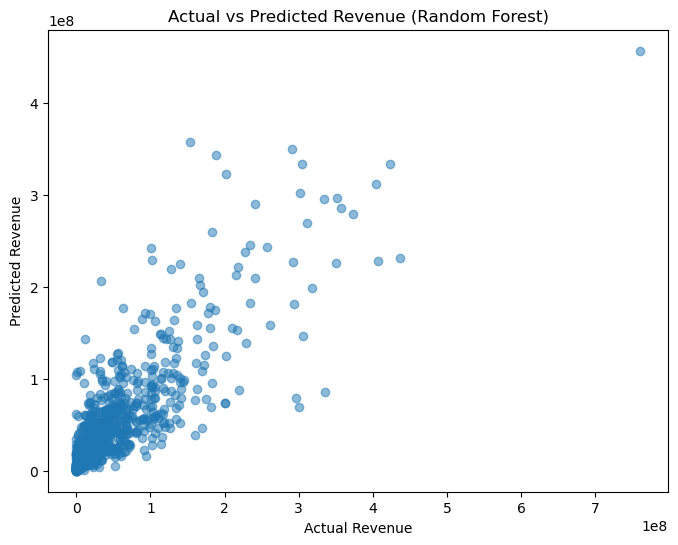

In [21]:
# Scatter plot of actual vs predicted revenue (Random Forest Regressor)

plt.figure(figsize=(8,6))
plt.scatter(y_test_reg, y_pred_rf_reg, alpha=0.5)
plt.title('Actual vs Predicted Revenue (Random Forest)')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.show()

In Step 8A, we tried to make our money prediction model smarter by using something called a Random Forest Regressor. A Random Forest is like asking a whole bunch of smaller decision trees to guess how much money a movie will make, and then taking the average answer. After training it, we found that the model could explain about 67% of how much money movies made, which is way better than before when it was only about 41%. The mistakes the model made (called MSE) were smaller too, even though movie money numbers are still really big. Overall, using a Random Forest helped our model become much better at understanding box office success!


This scatter plot shows how close the model's predictions were to the actual money movies made. Each dot is a movie but if the prediction were perfect, all the dots would form a straight diagonal line. In our case, the dots are mostly close to that line, especially for movies that made under $200 million. This means the model did a pretty good job predicting revenue for average movies, but it struggled more with very high-earning films (which are rare and hard to predict). Overall, the chart shows that the Random Forest model captured the general trend of movie revenue pretty well.



Step 8B: Train a Random Forest Model for Audience Rating Prediction (Classification)

In [24]:
# Step 8B: Random Forest Classifier for Audience Rating Prediction

from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_clf, y_train_clf)

# Predict on the test set
y_pred_rf_clf = rf_clf.predict(X_test_clf)

# Evaluate the model
accuracy_rf = accuracy_score(y_test_clf, y_pred_rf_clf)
f1_rf = f1_score(y_test_clf, y_pred_rf_clf, pos_label='High')

print("Random Forest Classification Accuracy:", accuracy_rf)
print("Random Forest Classification F1 Score:", f1_rf)

# Optional: Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_rf_clf))


Random Forest Classification Accuracy: 0.7997432605905006
Random Forest Classification F1 Score: 0.6736401673640168

Confusion Matrix:
[[161  94]
 [ 62 462]]


In Step 8B, we also used a Random Forest Classifier to try and better guess if a movie would be a "High" or "Low" success with audiences. Just like before, a Random Forest here means a lot of smaller decision trees vote on the answer. After training this model, we saw that it guessed correctly about 80% of the time and had an F1 score of about 67%, which was much better than our earlier model. This means it got a lot better at finding the movies that people would really like. Overall, the Random Forest Classifier made our success prediction smarter and more accurate!

Step 9A: Feature Importance for Random Forest Regressor (Revenue)

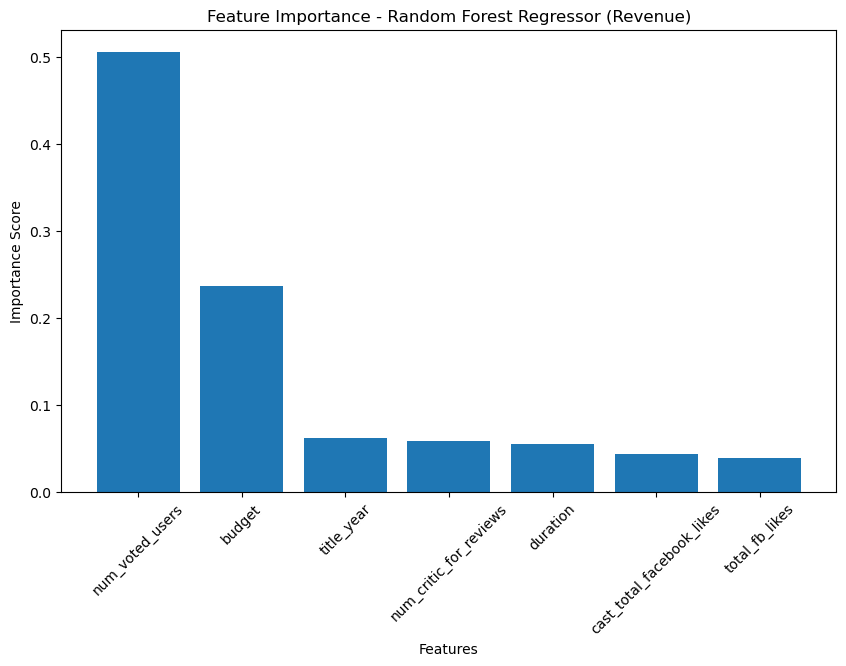

In [27]:
# Step 9A: Feature Importance for Random Forest Regressor (Revenue)

import matplotlib.pyplot as plt

# Get feature importances
importances = rf_reg.feature_importances_
feature_names = X_train_reg.columns

# Create a DataFrame for better plotting
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.bar(feat_importance_df['Feature'], feat_importance_df['Importance'])
plt.title('Feature Importance - Random Forest Regressor (Revenue)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.show()


In this chart, we see which things helped the model the most when guessing how much money a movie would make. The most important thing was how many people voted for the movie online. The more voters, the more money the movie usually made. Next was the movie’s budget. Big budget movies often earn more because they have better effects and more ads. Other things like the year the movie came out, how long it was, and how many critics reviewed it mattered a little, but not as much. Surprisingly, things like how many Facebook likes the actors got didn’t help the model much at all.

Step 9B: Feature Importance for Random Forest Classifier (Audience Rating)
Same idea but for the audience rating model.

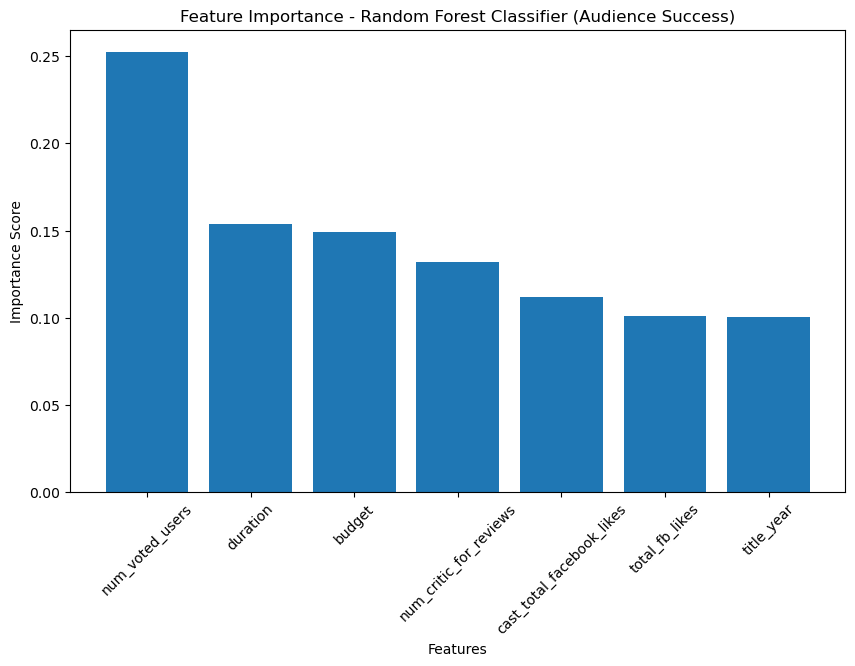

In [30]:
# Step 9B: Feature Importance for Random Forest Classifier (Audience Rating)

# Get feature importances
importances_clf = rf_clf.feature_importances_
feature_names_clf = X_train_clf.columns

# Create a DataFrame for better plotting
feat_importance_clf_df = pd.DataFrame({'Feature': feature_names_clf, 'Importance': importances_clf})
feat_importance_clf_df = feat_importance_clf_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.bar(feat_importance_clf_df['Feature'], feat_importance_clf_df['Importance'])
plt.title('Feature Importance - Random Forest Classifier (Audience Success)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.show()


In this chart, we see what helped the model figure out if a movie would be a "High" or "Low" success with audiences. The most important thing again was how many people voted for the movie online, which makes sense — more votes usually means more fans. The length of the movie and its budget also mattered a lot. That means longer and bigger-budget movies were more likely to be liked by audiences. Other things like critic reviews and Facebook likes for the actors also helped a little. Even the year the movie came out had a small effect. So, overall, the model looked at a bunch of clues, but it mainly relied on how popular the movie was online and how big and long it was.